# Quantum algorithms: Variational quantum algorithms

<Admonition type="note">

  *Approximate QPU time to run this experiment is 9 minutes (tested on ibm\_brisbane).*

  (this notebook might not evaluate in the time allowed on the Open Plan. Please use quantum computing resources wisely.)
</Admonition>



## 1. Introduction

This tutorial provides an overview of a hybrid quantum-classical algorithm, specifically focusing on the variational quantum eigensolver (VQE) and the quantum approximate optimization algorithm (QAOA). The primary objective of these algorithms is to tackle optimization problems by employing quantum circuits with parameterized quantum gates.

Despite the advancements in quantum computing, the presence of noise in current quantum devices makes it challenging to extract meaningful results from deep quantum circuits. To overcome this challenge, VQE and QAOA adopt a hybrid quantum-classical approach, which involves iteratively executing relatively short quantum circuits using quantum computation and optimizing the parameters of the target parametrized quantum circuits using classical computation.

QAOA has the potential to provide the optimal solutions to the target problems at a utility scale, thanks to the application of various error mitigation and suppression techniques. VQE has many applications (like quantum chemistry) in which it is less scalable. But there have been a number of eigenvalue-related approaches that have emerged to complement and augment VQE, including Krylov subspace diagonalization and sampling-based quantum diagonalization (SQD). Understanding VQE is an important first step in understanding the wide range of classical-quantum hybrid algorithms that have emerged.

This module describes the fundamental concepts and implementation of VQE and QAOA. Further tutorials will explore advanced topics and techniques for scaling up these algorithms.



You require the following library in your environment to run this notebook.
If you have not installed it yet, you can install it by un-commenting and running the following cell.



In [ ]:
#Installing the required libraries

# Install Qiskit and upgrade to the latest version
%pip install qiskit --upgrade

# Install the Qiskit Aer library for simulation
%pip install qiskit qiskit-aer --upgrade

# Install Qiskit visualization tools
%pip install qiskit[visualization] --upgrade

# Install Qiskit IBM Rumtime
%pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=2f1f0c3d2f03be7940efd58971ebcaa14059348b8e94a8066ba438b7b02b3866
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# % pip install qiskit[visualization] qiskit-ibm-runtime

## 2. Computing the minimum eigenvalue of a simple Hamiltonian

We will start by applying VQE to a very simple case, to see how it works. We will compute the minimum eigenvalue of Pauli $Z$ matrix with VQE. We will start by importing some general packages.



In [ ]:
import numpy as np
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize

We now define the operator of interest and view it in matrix form.



In [ ]:
op = SparsePauliOp("Z")
op.to_matrix()

array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])

It is easy to obtain the eigenvalues classically, so we can check our work. This might become difficult as we scale toward utility. Here we use numpy.



In [ ]:
# compute eigenvalues with numpy
result = np.linalg.eigh(op.to_matrix())
print("Eigenvalues:", result.eigenvalues)

Eigenvalues: [-1.  1.]


To obtain eigenvalues using a variational quantum algorithm, we construct a circuit with gates that take variational parameters:



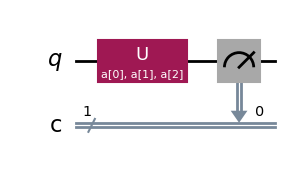

In [ ]:
# define a variational form
param = ParameterVector("a", 3)
qc = QuantumCircuit(1, 1)
qc.u(param[0], param[1], param[2], 0)
qc_estimator = qc.copy()
qc.measure(0, 0)
qc.draw("mpl")

If we want to estimate the expectation value of an operator (like $Z$), we should use estimator. If we want to look at the states of the system, we use sampler.



In [ ]:
sampler = StatevectorSampler()
estimator = StatevectorEstimator()

We can compute counts of bitstrings 0 and 1 with random parameter values `[1, 2, 3]` using Sampler.



In [ ]:
# compute counts of bitstrings with random parameter values by Sampler
result = sampler.run([(qc, [1, 2, 3])]).result()
counts = result[0].data.c.get_counts()
counts

{'0': 777, '1': 247}

We know that we can compute the expectation value of Z by $\langle Z \rangle = p_0 - p_1$ with probabilities $\{0: p_0, 1: p_1\}$.



In [ ]:
# compute the expectation value of Z based on the counts
(counts.get("0", 0) - counts.get("1", 0)) / sum(counts.values())

0.517578125

This circuit worked, but the parameter values chosen did not correspond to a very low-energy (or low-eigenvalue) state. The eigenvalue obtained is quite a bit higher than the minimum. The result is similar when using estimator.

Note that Estimator takes quantum circuits without measurements.



In [ ]:
result = estimator.run([(qc_estimator, op, [1, 2, 3])]).result()
result[0].data.evs

array(0.54030231)

We will need to search through parameters and find those that yield the lowest eigenvalue.
We make a function to receive parameter values of the variational form and return the expectation value $\langle Z \rangle$.



In [ ]:
# define a cost function to look for the minimum eigenvalue of Z
def cost(x):
    result = sampler.run([(qc, x)]).result()
    counts = result[0].data.c.get_counts()
    expval = (counts.get("0", 0) - counts.get("1", 0)) / sum(counts.values())
    # the following line shows the trajectory of the optimization
    print(expval, counts)
    return expval

Let's apply SciPy's `minimize` function to find the minimum eigenvalue of Z.



In [ ]:
# minimize the cost function with scipy's minimize
min_result = minimize(cost, [0, 0, 0], method="COBYLA", tol=1e-8)
min_result

1.0 {'0': 1024}
0.55078125 {'0': 794, '1': 230}
0.529296875 {'0': 783, '1': 241}
0.51953125 {'0': 778, '1': 246}
-0.41796875 {'0': 298, '1': 726}
-0.66796875 {'0': 170, '1': 854}
-0.431640625 {'1': 733, '0': 291}
-0.59375 {'1': 816, '0': 208}
-0.181640625 {'1': 605, '0': 419}
-0.990234375 {'1': 1019, '0': 5}
-0.412109375 {'1': 723, '0': 301}
-0.984375 {'1': 1016, '0': 8}
-0.8203125 {'1': 932, '0': 92}
-0.98828125 {'1': 1018, '0': 6}
-0.99609375 {'1': 1022, '0': 2}
-0.994140625 {'1': 1021, '0': 3}
-0.990234375 {'1': 1019, '0': 5}
-0.99609375 {'1': 1022, '0': 2}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-1.0 {'1': 1024}


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -1.0
       x: [ 3.176e+00  1.242e+00  1.079e+00]
    nfev: 39
   maxcv: 0.0

In [ ]:
# check counts of bitstrings with the optimal parameters
result = sampler.run([(qc, min_result.x)]).result()
result[0].data.c.get_counts()

{'1': 1024}

### 2.1 Exercise

Compute the minimum eigenvalue of $Z \otimes Z$ with VQE.



In [ ]:
z2 = SparsePauliOp("ZZ")
print(z2)
print(z2.to_matrix())

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [ ]:
# compute eigenvalues with numpy

In [ ]:
# define a variational form
# qc = ...

In [ ]:
# compute counts of bitstrings with a random parameter values by Sampler
# result = sampler.run(...)
# result

In [ ]:
# compute the expectation value of ZZ based on the counts

In [ ]:
# verify the expectation value of ZZ with Estimator

In [ ]:
# define a cost function to look for the minimum eigenvalue of ZZ
# def cost(x):
#    expval = ...
#    return expval

In [ ]:
# minimize the cost function with scipy's minimize
# min_result = minimize(cost, [...], method="COBYLA", tol=1e-8)
# min_result

In [ ]:
# check counts of bitstrings with the optimal parameter values
# result = sampler.run(qc, min_result.x).result()
# result

#### Solutions of the exercise



We define the operator of interest and view it in matrix form.



In [ ]:
z2 = SparsePauliOp("ZZ")
print(z2)
print(z2.to_matrix())

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


To obtain eigenvalues using a variational quantum algorithm, we construct a circuit with gates that take variational parameters:



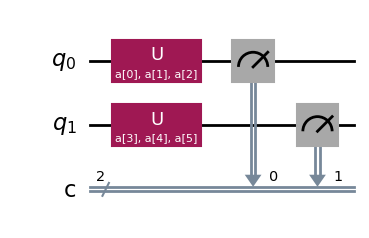

In [ ]:
# define a variational form
param = ParameterVector("a", 6)
qc = QuantumCircuit(2, 2)
qc.u(param[0], param[1], param[2], 0)
qc.u(param[3], param[4], param[5], 1)
qc_estimator = qc.copy()
qc.measure([0, 1], [0, 1])
qc.draw("mpl")

If we want to estimate the expectation value of an operator (like $Z \otimes Z$), we would use estimator. If we want to look at the states of the system, we use sampler.



In [ ]:
sampler = StatevectorSampler()
estimator = StatevectorEstimator()

In [ ]:
# compute counts of bitstrings with random parameter values by Sampler
result = sampler.run([(qc, [1, 2, 3, 4, 5, 6])]).result()
counts = result[0].data.c.get_counts()
counts

{'10': 661, '11': 203, '01': 47, '00': 113}

In [ ]:
# compute the expectation value of ZZ based on the counts
(
    counts.get("00", 0)
    - counts.get("01", 0)
    - counts.get("10", 0)
    + counts.get("11", 0)
) / sum(counts.values())

0.0

This circuit worked, but the parameter values chosen did not correspond to a very low-energy (or low-eigenvalue) state. The eigenvalue obtained is quite a bit higher than the minimum. The result is similar when using estimator.



In [ ]:
# verify the expectation value of ZZ with Estimator
result = estimator.run([(qc_estimator, z2, [1, 2, 3, 4, 5, 6])]).result()
result[0].data.evs

array(-0.35316516)

We will need to search through parameters and find those that yield the lowest eigenvalue.



In [ ]:
# define a cost function to look for the minimum eigenvalue of ZZ
def cost(x):
    result = sampler.run([(qc, x)]).result()
    counts = result[0].data.c.get_counts()
    expval = (
        counts.get("00", 0)
        - counts.get("01", 0)
        - counts.get("10", 0)
        + counts.get("11", 0)
    ) / sum(counts.values())
    print(expval, counts)
    return expval

In [ ]:
# minimize the cost function with scipy's minimize
min_result = minimize(cost, [0, 0, 0, 0, 0, 0], method="COBYLA", tol=1e-8)
min_result

1.0 {'00': 1024}
0.50390625 {'01': 254, '00': 770}
0.556640625 {'00': 797, '01': 227}
0.544921875 {'00': 791, '01': 233}
0.28515625 {'00': 596, '11': 62, '10': 177, '01': 189}
0.3203125 {'00': 619, '10': 179, '01': 169, '11': 57}
0.298828125 {'00': 615, '01': 175, '10': 184, '11': 50}
-0.00390625 {'01': 377, '10': 137, '00': 220, '11': 290}
0.380859375 {'11': 691, '01': 251, '10': 66, '00': 16}
-0.11328125 {'01': 485, '00': 233, '11': 221, '10': 85}
-0.2109375 {'01': 546, '11': 248, '00': 156, '10': 74}
-0.1875 {'01': 571, '00': 82, '11': 334, '10': 37}
-0.1640625 {'10': 70, '11': 270, '01': 526, '00': 158}
-0.24609375 {'00': 151, '01': 574, '11': 235, '10': 64}
-0.259765625 {'01': 582, '11': 242, '10': 63, '00': 137}
-0.28515625 {'10': 57, '01': 601, '11': 212, '00': 154}
-0.251953125 {'01': 586, '00': 179, '11': 204, '10': 55}
-0.28125 {'01': 609, '00': 153, '11': 215, '10': 47}
-0.283203125 {'00': 135, '01': 614, '11': 232, '10': 43}
-0.283203125 {'01': 606, '11': 207, '00': 160, '1

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.369140625
       x: [ 2.239e+00 -3.993e-01 -6.955e-01  1.056e+00 -1.640e-01
           -1.704e-01]
    nfev: 97
   maxcv: 0.0

We obtained an eigenvalue extremely close to the minimum given to us from numpy.



In [ ]:
# check counts of bitstrings with the optimal parameters
result = sampler.run([(qc, min_result.x)]).result()
result[0].data.c.get_counts()

{'01': 609, '11': 208, '00': 169, '10': 38}

## 3. Quantum Optimization with Qiskit patterns

In this how-to we will learn about Qiskit patterns and quantum approximate optimization. A Qiskit pattern is an intuitive, repeatable set of steps for implementing a quantum computing workflow:



Qiskit Pattern
https://quantum.cloud.ibm.com/docs/en/guides/intro-to-patterns

We will apply the patterns to the context of **combinatorial optimization** and show how to solve the **Max-Cut** problem using the **Quantum Approximate Optimization Algorithm (QAOA)**, a hybrid (quantum-classical) iterative method.

Note that this QAOA part is based on "Part 1: Small-scale QAOA" of the [Quantum approximate optimization algorithm](/docs/tutorials/quantum-approximate-optimization-algorithm) tutorial. See the tutorial to learn how to scale it up.



### 3.1 (Small-scale) Qiskit pattern for optimization



This part will use a small-scale Max-Cut problem to illustrate the steps required to solve an optimization problem using a quantum computer.



The Max-Cut problem is an optimization problem that is hard to solve (more specifically, it is an NP-hard problem) with a number of different applications in clustering, network science, and statistical physics. This tutorial considers a graph of nodes connected by edges and aims to partition the nodes into two sets by "cutting" edges, such that the number of edges cut is maximized.



To give some context before mapping this problem to a quantum algorithm, you can better understand how the Max-Cut problem becomes a classical combinatorial optimization problem by first considering the minimization of a function $f(x)$

$$
\min_{x\in \{0, 1\}^n}f(x),
$$

where the input $x$ is a vector whose components correspond to each node of a graph.  Then, constrain each of these components to be either $0$ or $1$ (which represent being included or not included in the cut). This small-scale example case uses a graph with $n=5$ nodes.

You could write a function of a pair of nodes $i,j$ which indicates whether the corresponding edge $(i,j)$ is in the cut. For example, the function $x_i + x_j - 2 x_i x_j$ is 1 only if one of either $x_i$ or $x_j$ are 1 (which means that the edge is in the cut) and zero otherwise. The problem of maximizing the edges in the cut can be formulated as

$$
\max_{x\in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2 x_i x_j,
$$

which can be rewritten as a minimization of the form

$$
\min_{x\in \{0, 1\}^n} \sum_{(i,j)}  2 x_i x_j - x_i - x_j.
$$

The minimum of $f(x)$ in this case is when the number of edges traversed by the cut is maximal. As you can see, there is nothing relating to quantum computing yet. You need to reformulate this problem into something that a quantum computer can understand.



Initialize your problem by creating a graph with $n=5$ nodes.



In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw

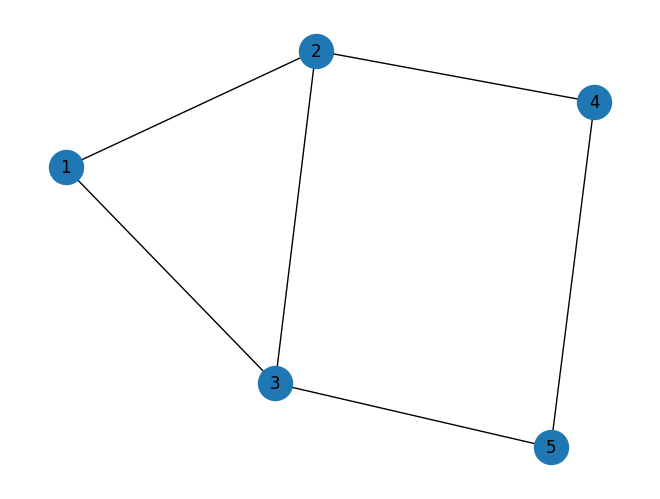

In [ ]:
n = 5

graph = rx.PyGraph()
graph.add_nodes_from(range(1, n + 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (1, 2, 1.0),
    (1, 3, 1.0),
    (2, 4, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
pos = rx.spring_layout(graph, seed=2)
mpl_draw(graph, node_size=600, pos=pos, with_labels=True, labels=str)

### 3.2 Step 1. Map classical inputs to a quantum problem

The first step of the pattern is to map the classical problem (graph) into quantum **circuits** and **operators**. To do this, there are three main steps to take:

1.  Utilize a series of mathematical reformulations, to represent this problem using the Quadratic Unconstrained Binary Optimization (QUBO) problems notation.
2.  Rewrite the optimization problem as a Hamiltonian for which the ground state corresponds to the solution which minimizes the cost function.
3.  Create a quantum circuit which will prepare the ground state of this Hamiltonian via a process similar to quantum annealing.

**Note:** In the QAOA methodology, you ultimately want to have an operator (**Hamiltonian**) that represents the **cost function** of our hybrid algorithm, as well as a parametrized circuit (**Ansatz**) that represents quantum states with candidate solutions to the problem. You can sample from these candidate states and then evaluate them using the cost function.

#### Graph → optimization problem

The first step of the mapping is a notation change, The following expresses the problem in QUBO notation:

$$
\min_{x\in \{0, 1\}^n}x^T Q x,
$$

where $Q$ is a $n\times n$ matrix of real numbers, $n$ corresponds to the number of nodes in your graph, $x$ is the vector of binary variables introduced above, and $x^T$ indicates the transpose of the vector $x$.



```
Problem name: maxcut

Minimize
  2*x_1*x_2 + 2*x_1*x_3 + 2*x_2*x_3 + 2*x_2*x_4 + 2*x_3*x_5 + 2*x_4*x_5 - 2*x_1
  - 3*x_2 - 3*x_3 - 2*x_4 - 2*x_5

Subject to
  No constraints

  Binary variables (5)
    x_1 x_2 x_3 x_4 x_5
```



#### Optimization problem → Hamiltonian

You can then reformulate the QUBO problem as a **Hamiltonian** (here, a matrix that represents the energy of a system):

$$
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
$$

**Reformulation steps from the QAOA problem to the Hamiltonian**

To demonstrate how the QAOA problem can be rewritten in this way, first replace the binary variables $x_i$ to a new set of variables $z_i\in\{-1, 1\}$ via

$$
x_i = \frac{1-z_i}{2}.
$$

Here you can see that if $x_i$ is $0$, then $z_i$ must be $1$. When the $x_i$'s are substituted for the $z_i$'s in the optimization problem ($x^TQx$), an equivalent formulation can be obtained.

$$
x^TQx=\sum_{ij}Q_{ij}x_ix_j \\ =\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j) \\=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
$$

Now if we define $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$, remove the prefactor, and the constant $n^2$ term, we arrive at the two equivalent formulations of the same optimization problem.

$$
min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
$$

Here, $b$ depends on $Q$. Note that to obtain $z^TQz + b^Tz$ we dropped the factor of 1/4 and a constant offset of $n^2$ which do not play a role in the optimization.

Now, to obtain a quantum formulation of the problem, promote the $z_i$ variables to a Pauli $Z$ matrix, such as a $2\times 2$ matrix of the form

$$
Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
$$

When you substitute these matrices in the optimization problem above, you obtain the following Hamiltonian

$$
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
$$

*Also recall that the $Z$ matrices are embedded in the quantum computer's computational space, that is, a Hilbert space of size $2^n\times 2^n$. Therefore, you should understand terms such as $Z_iZ_j$ as the tensor product $Z_i\otimes Z_j$ embedded in the $2^n\times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ where $I$ is the $2\times 2$ identity matrix.*

This Hamiltonian is called the <b>cost function Hamiltonian</b>. It has the property that its ground state corresponds to the solution that <b>minimizes the cost function $f(x)$</b>.
Therefore, to solve your optimization problem you now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $\min~f(x)$.



In [ ]:
def build_max_cut_operator(graph: rx.PyGraph) -> tuple[SparsePauliOp, float]:
    sp_list = []
    constant = 0
    for s, t in graph.edge_list():
        w = graph.get_edge_data(s, t)
        sp_list.append(("ZZ", [s, t], w / 2))
        constant -= 1 / 2
    return SparsePauliOp.from_sparse_list(
        sp_list, num_qubits=graph.num_nodes()
    ), constant

In [ ]:
cost_hamiltonian, constant = build_max_cut_operator(graph)
print("Cost Function Hamiltonian:", cost_hamiltonian)
print("Constant:", constant)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'IIZZI', 'IZIZI', 'ZIZII', 'ZZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
Constant: -3.0


#### Hamiltonian → quantum circuit



The Hamiltonian $H_C$ contains the quantum definition of your problem. Now you can create a quantum circuit that will help *sample* good solutions from the quantum computer. The QAOA is inspired by quantum annealing and applies alternating layers of operators in the quantum circuit.

The general idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that you are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_m\}$ with angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$.

The quantum circuit that you generate is **parametrized** by $\gamma_i$ and $\beta_i$, so you can try out different values of $\gamma_i$ and $\beta_i$ and sample from the resulting state.



In this case we will try an example with 1 QAOA layer that contains two parameters: $\gamma_1$ and $\beta_1$.



In [ ]:
from qiskit.circuit.library import QAOAAnsatz

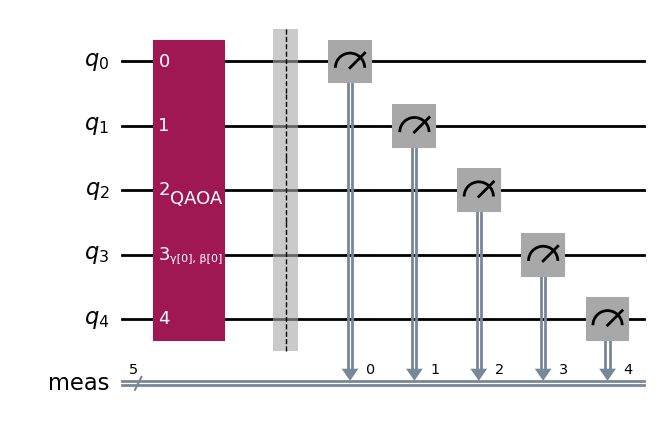

In [ ]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
circuit.measure_all()
circuit.draw("mpl")

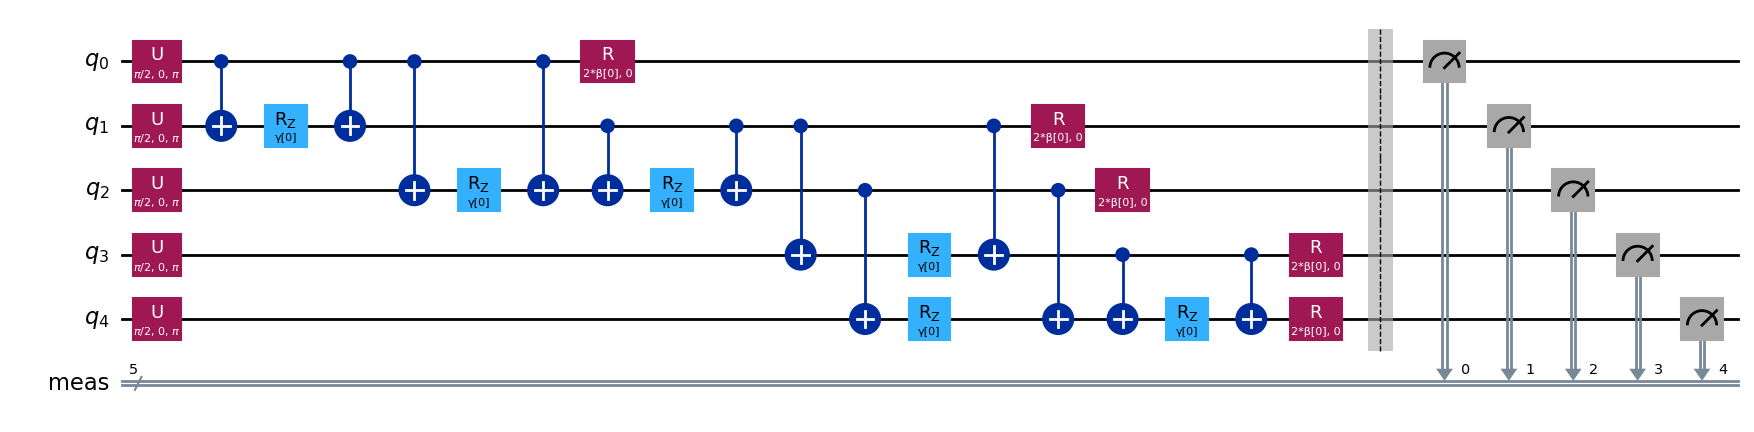

In [ ]:
circuit.decompose(reps=3).draw("mpl", fold=-1)

In [ ]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

### 3.3 Step 2. Optimize circuits for quantum hardware execution



The circuit above contains a series of abstractions useful to think about quantum algorithms, but not possible to run on the hardware. To be able to run on a QPU, the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern.

The Qiskit library offers a series of **transpilation passes** that cater to a wide range of circuit transformations. You need to make sure that your circuit is **optimized** for your purpose.

Transpilation might involves several steps, such as:

*   **Initial mapping** of the qubits in the circuit (such as decision variables) to physical qubits on the device.
*   **Unrolling** of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.
*   **Routing** of any qubits in the circuit that interact to physical qubits that are adjacent with one another.
*   **Error suppression** by adding single-qubit gates to suppress noise with dynamical decoupling.

More information about transpilation is available in our [documentation](/docs/guides/transpile).

The following code transforms and optimizes the abstract circuit into a format that is ready for execution on one of devices accessible through the cloud using the **Qiskit IBM® Runtime service**.

Note that you can test your programs locally by "local testing mode" before sending them to real quantum computers.
More information about the local testing mode is available in the [documentation.](/docs/guides/local-testing-mode)



In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Use a quantum device
service = QiskitRuntimeService()
backend = service.least_busy(min_num_qubits=127)
# backend = service.backend("ibm_kingston")

# You can test your programs locally with a fake backend (local testing mode)
# backend = FakeBrisbane()

print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

  service = QiskitRuntimeService(channel="ibm_quantum_platform")


<IBMBackend('ibm_strasbourg')>


<Image src="/learning/images/courses/utility-scale-quantum-computing/variational-quantum-algorithms/extracted-outputs/95cd3eed-0348-4373-b664-16a65d42f1e7-2.avif" alt="Output of the previous code cell" />

### 3.4 Step 3. Execute using Qiskit primitives



In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal $\beta_k$ and $\gamma_k$ parameters. This execution loop is executed via the following steps:

1.  Define the initial parameters
2.  Instantiate a new `Session` containing the optimization loop and the primitive used to sample the circuit
3.  Once an optimal set of parameters is found, execute the circuit a final time to obtain a final distribution which will be used in the post-process step.



#### Define circuit with initial parameters

We start with arbitrary chosen parameters.



In [ ]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_gamma, initial_beta]

#### Define backend and execution primitive

Use the **Qiskit Runtime primitives** to interact with IBM® backends. The two primitives are Sampler and Estimator, and the choice of primitive depends on what type of measurement you want to run on the quantum computer. For the minimization of $H_C$, use the Estimator since the measurement of the cost function is simply the expectation value of $\langle H_C \rangle$.



#### Run

The primitives offer a variety of [execution modes](/docs/guides/execution-modes) to schedule workloads on quantum devices, and a QAOA workflow runs iteratively in a session.



You can plug the sampler-based cost function into the SciPy minimizing routine to find the optimal parameters.



In [ ]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [ ]:
from qiskit_ibm_runtime import Session, EstimatorV2
from scipy.optimize import minimize

objective_func_vals = []  # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = EstimatorV2(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

The optimizer was able to reduce the cost and find better parameters for the circuit.



In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

<Image src="/learning/images/courses/utility-scale-quantum-computing/variational-quantum-algorithms/extracted-outputs/f923dd5d-0.avif" alt="Output of the previous code cell" />

Once you have found the optimal parameters for the circuit, you can assign these parameters and sample the final distribution obtained with the optimized parameters. Here is where the *Sampler* primitive should be used since it is the probability distribution of bitstring measurements which correspond to the optimal cut of the graph.

**Note:** This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state - for example, `010101110000...` - which corresponds to a candidate solution $x$ to our initial optimization problem ($\max f(x)$ or $\min f(x)$ depending on the task).



In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

<Image src="/learning/images/courses/utility-scale-quantum-computing/variational-quantum-algorithms/extracted-outputs/f8dddf5a-0.avif" alt="Output of the previous code cell" />

In [ ]:
from qiskit_ibm_runtime import SamplerV2

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = SamplerV2(mode=backend)

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{12: 0.0652, 31: 0.0089, 4: 0.0085, 13: 0.0731, 26: 0.0256, 28: 0.0246, 17: 0.0405, 25: 0.0591, 20: 0.031, 15: 0.0221, 8: 0.017, 21: 0.0371, 14: 0.0461, 16: 0.0229, 19: 0.0723, 23: 0.0199, 22: 0.0478, 18: 0.0708, 24: 0.0165, 6: 0.0525, 7: 0.0155, 5: 0.0245, 3: 0.0231, 29: 0.0121, 30: 0.0062, 10: 0.0363, 1: 0.0097, 9: 0.042, 27: 0.0094, 11: 0.0349, 0: 0.0129, 2: 0.0119}


### 3.5 Step 4. Post-process, return result in classical format

The post-processing step interprets the sampling output to return a solution for your original problem. In this case, you are interested in the bitstring with the highest probability as this determines the optimal cut. The symmetries in the problem allow for four possible solutions, and the sampling process will return one of them with a slightly higher probability, but you can see in the plotted distribution below that four of the bitstrings are distinctively more likely than the rest.



In [ ]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]


keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1, 1, 0]


In [ ]:
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[p[0].item()].set_color("tab:purple")
plt.show()

<Image src="/learning/images/courses/utility-scale-quantum-computing/variational-quantum-algorithms/extracted-outputs/32a3020e-c1ea-4aff-988c-d7910a690fa8-0.avif" alt="Output of the previous code cell" />

#### Visualize best cut

From the optimal bit string, you can then visualize this cut on the original graph.



In [ ]:
colors = ["tab:grey" if i == 0 else "tab:purple" for i in most_likely_bitstring]
mpl_draw(graph, node_size=600, pos=pos, with_labels=True, labels=str, node_color=colors)

<Image src="/learning/images/courses/utility-scale-quantum-computing/variational-quantum-algorithms/extracted-outputs/22a48124-e6b4-4144-bee1-f01fa4c7ccbb-0.avif" alt="Output of the previous code cell" />

And calculate the value of the cut. The solution is not optimal due to noise (the cut value of the optimal solution is 5).



In [ ]:
from typing import Sequence


def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(
        list(graph.nodes())
    ), "The length of x must coincide with the number of nodes in the graph."
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list())
    )


cut_value = evaluate_sample(most_likely_bitstring, graph)
print("The value of the cut is:", cut_value)

The value of the cut is: 5


This concludes the small-scale QAOA tutorial.
You will learn how to adapt QAOA at a utility-scale in "Part 2: scale it up!" of the [Quantum approximate optimization algorithm](/docs/tutorials/quantum-approximate-optimization-algorithm) tutorial.



In [ ]:
# Check Qiskit version
import qiskit

qiskit.__version__

'2.0.2'

© IBM Corp., 2017-2025